### 1. **Import Libraries**

In [2]:
import cv2
import numpy as np
from joblib import Parallel, delayed
from sklearn.linear_model import OrthogonalMatchingPursuit
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity


### 2. **Video Loading and Initialization**

Input video, read frames, and convert frames from BGR to Grayscale. 
                
The experiments are conducted on the `Big Buck Bunny' test sequence. (Source: https://test-videos.co.uk/bigbuckbunny/mp4-h264 ) 

In [3]:
def open_video(path):
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open video: {path}")
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    w   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    return cap, fps, w, h

In [ ]:
video_path = r"C:\Users\Lenovo\Desktop\IP_Milestine\optical_flow_based\BBB.mp4"
cap, fps, W, H = open_video(video_path)

ret, prev = cap.read()
if not ret:
    raise RuntimeError("Failed first frame")
prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)

### 3. **Optical flow extraction and visualization**

Dense optical flow is computed between consecutive frames using the Farnebäck algorithm.  
Each optical flow field contains horizontal and vertical motion components for every pixel and serves as the motion representation to be compressed.

- Open video and read frames.       
- Convert to grayscale and compute dense optical flow between consecutive frames using Farneback's method.      
- Store the flow field and frames.

In [5]:
flows = []
frames = [prev]
while True:
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Farneback method
    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray,
                                        None,
                                        pyr_scale=0.5,
                                        levels=3,
                                        winsize=15,
                                        iterations=3,
                                        poly_n=5,
                                        poly_sigma=1.2,
                                        flags=0)
    flows.append(flow.astype(np.float32))
    frames.append(frame)
    prev_gray = gray
cap.release()
print(f"Extracted {len(flows)} flow fields for {len(frames)-1} pairs; fps={fps:.2f}")

Extracted 599 flow fields for 599 pairs; fps=60.00


##### Optical flow visualization on first frame

In [6]:

def draw_flow(img_gray, flow, step=8, scale=6, color=(0,0,255)):
    h, w = img_gray.shape[:2]
    y, x = np.mgrid[step//2:h:step, step//2:w:step].reshape(2, -1).astype(int)
    fx, fy = flow[y, x].T
    vis = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
    for (x1, y1, dx, dy) in zip(x, y, fx, fy):
        x2 = int(x1 + scale * dx)
        y2 = int(y1 + scale * dy)
        cv2.arrowedLine(vis, (x1, y1), (x2, y2), color, 1, tipLength=0.35)
    return vis

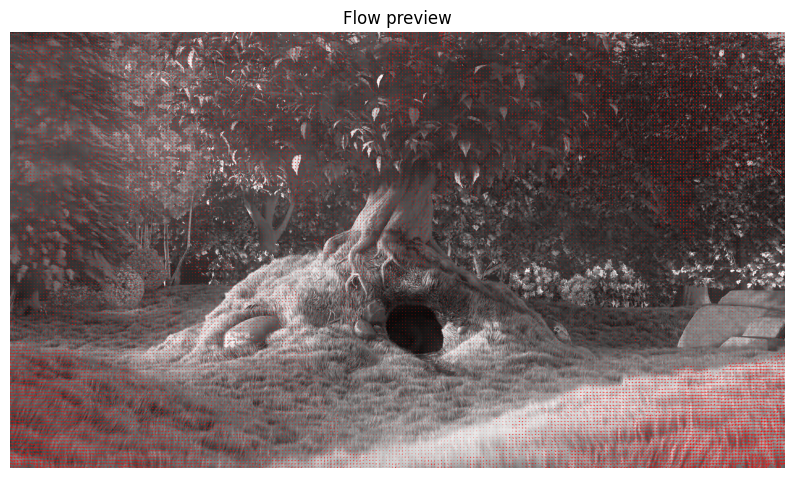

(1080, 1920, 2)


In [26]:
first_gray = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)
vis = draw_flow(first_gray, flows[0])
plt.figure(figsize=(10,7)); plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.title("Flow preview"); plt.show()
print(flow.shape)


Zoomed optical flow visualization:  
The optical flow within a region of interest is visualized at higher resolution to clearly observe motion patterns.

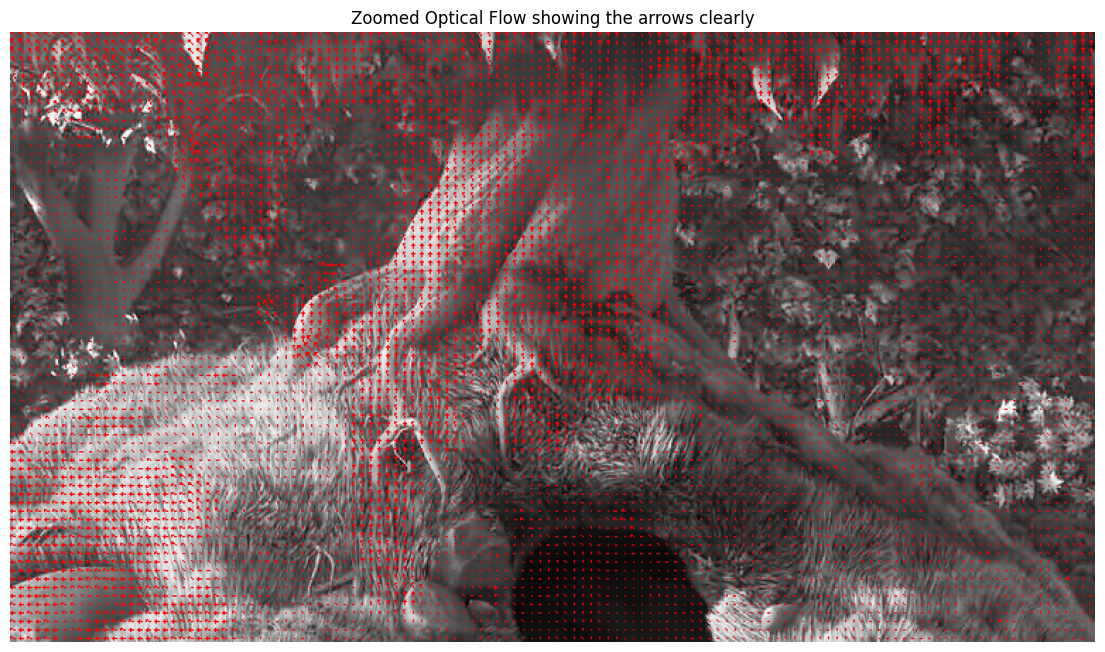

In [ ]:

# Choosing central portion of frame
h1, w1 = first_gray.shape
roi_x1, roi_y1 = int(0.3*w1), int(0.3*h1)
roi_x2, roi_y2 = int(0.7*w1), int(0.7*h1)

# Bunny area 
# roi_x1, roi_y1 = int(0.35*w), int(0.45*h)
# roi_x2, roi_y2 = int(0.65*w), int(0.75*h)

roi_gray = first_gray[roi_y1:roi_y2, roi_x1:roi_x2]
roi_flow = flows[0][roi_y1:roi_y2, roi_x1:roi_x2]

roi_vis = draw_flow(roi_gray, roi_flow, step=6, scale=10)

plt.figure(figsize=(14, 9))
plt.imshow(cv2.cvtColor(roi_vis, cv2.COLOR_BGR2RGB))
plt.title("Zoomed Optical Flow showing the arrows clearly")
plt.axis('off')
plt.show()

### 4. **Compressive sensing on motion field**

The optical flow is processed in non-overlapping spatial blocks.  
For each block:
- Horizontal and vertical motion components are concatenated into a single vector.
- A fixed Gaussian random sensing matrix $\Phi$ of size mxn (m<< n) is used to obtain compressed measurements.
  
The number of measurements is set to 25% of the original signal dimensionality.

In [9]:
def gaussian_phi(n, m, seed=42):
    rng = np.random.default_rng(seed)
    return (rng.standard_normal((m, n)) / np.sqrt(m)).astype(np.float32)

In [10]:
block = 16
# Generating Sensing matrix Φ (same for all blocks/frames)
n = 2 * block * block #  n=2*16*16=512
m = n // 4  # n/4 ~ 25 % measurement considered
Phi = gaussian_phi(n, m, seed=42) #Gaussian random matrix
print(f"m={m},n={n}")

m=128,n=512


##### Block-Based Representation of Optical Flow

- Each optical flow field is divided into blocks of size 16x16  
- For every block, the horizontal and vertical motion components are flattened and concatenated to form a single vector suitable for transform-domain processing.


In [11]:
def blockify(flow, block):
    H, W, _ = flow.shape
    Hc, Wc = (H//block)*block, (W//block)*block
    flow = flow[:Hc, :Wc]
    blocks = []
    for y in range(0, Hc, block):
        for x in range(0, Wc, block):
            u = flow[y:y+block, x:x+block, 0]
            v = flow[y:y+block, x:x+block, 1]
            blocks.append(np.concatenate([u.flatten(), v.flatten()]))        
    return np.array(blocks), (Hc, Wc)

#### Sparse Representation using Discrete Cosine Transform (DCT)

- To promote sparsity, each optical flow block is transformed into the DCT domain.  
- The assumption is that motion vectors are more compressible when represented in a frequency domain.

In [12]:
def dct2(block):
    return cv2.dct(block.astype(np.float32))

def dct_block_vector(vec, block=16):
    # vec = [u_flat, v_flat]
    u = vec[:block*block].reshape(block, block)
    v = vec[block*block:].reshape(block, block)
    u_dct = dct2(u)
    v_dct = dct2(v)
    # ve=np.concatenate([u_dct.flatten(), v_dct.flatten()])
    # print(ve.shape)
    return np.concatenate([u_dct.flatten(), v_dct.flatten()])

def dct_transform_blocks(blocks, block=16):
    return np.vstack([dct_block_vector(b, block) for b in blocks])

#### Sparse Recovery via Orthogonal Matching Pursuit (OMP)

- Sparse reconstruction is performed using Orthogonal Matching Pursuit (OMP) algorithm.  
- Given the compressed measurements and sensing matrix, OMP recovers a sparse estimate of the DCT coefficients for each block independently.  
- Parallel processing is used to accelerate reconstruction.


In [13]:
def omp_reconstruct_matrix(Y, Phi, K=30, n_jobs=-1):
    # Solve each row independently: min ||y - Phi z|| s.t. ||z||_0 <= K
    def solve(y):
        omp = OrthogonalMatchingPursuit(n_nonzero_coefs=K)
        omp.fit(Phi, y)
        return omp.coef_.astype(np.float32)
    Z = Parallel(n_jobs=n_jobs, backend='loky')(delayed(solve)(y) for y in Y)
    return np.vstack(Z)

#### Inverse Transform and Flow Reconstruction

The recovered sparse DCT coefficients are transformed back to the spatial domain using the inverse DCT.  

In [14]:
def idct2(block):
    return cv2.idct(block.astype(np.float32))

def idct_block_vector(vec_dct, block=16):
    u_dct = vec_dct[:block*block].reshape(block, block)
    v_dct = vec_dct[block*block:].reshape(block, block)
    u = idct2(u_dct)
    v = idct2(v_dct)
    return np.concatenate([u.flatten(), v.flatten()])

def idct_transform_blocks(blocks_dct, block=16):
    return np.vstack([idct_block_vector(b, block) for b in blocks_dct])

Reconstructed blocks are reassembled to form the full optical flow field.

In [15]:
def deblock(block_vectors, shape_hw, block=16):
    Hc, Wc = shape_hw
    flow = np.zeros((Hc, Wc, 2), dtype=np.float32)
    idx = 0
    for y in range(0, Hc, block):
        for x in range(0, Wc, block):
            vec = block_vectors[idx]
            u = vec[:block*block].reshape(block, block)
            v = vec[block*block:].reshape(block, block)
            flow[y:y+block, x:x+block, 0] = u
            flow[y:y+block, x:x+block, 1] = v
            idx += 1
    return flow

#### Optical Flow Reconstruction Metrics

The reconstructed optical flow is evaluated against the original flow using:
- End-Point Error (EPE), measuring vector magnitude error
- Average Angular Error, measuring directional consistency



In [16]:
def flow_epe(gt_flow, rec_flow):
    diff = gt_flow - rec_flow
    return np.mean(np.sqrt(np.sum(diff**2, axis=-1)))

def flow_angular_error(gt_flow, rec_flow, eps=1e-6):
    # angle between vectors
    u1, v1 = gt_flow[...,0], gt_flow[...,1]
    u2, v2 = rec_flow[...,0], rec_flow[...,1]
    dot = u1*u2 + v1*v2
    n1  = np.sqrt(u1*u1 + v1*v1) + eps
    n2  = np.sqrt(u2*u2 + v2*v2) + eps
    cosang = np.clip(dot / (n1*n2), -1.0, 1.0)
    return np.degrees(np.mean(np.arccos(cosang)))


### 5. **Block-wise Compressed Sensing Reconstruction of Optical Flow**

Processing Steps

For each optical flow field extracted from the video:

1. **Block Partitioning**
   - The dense optical flow field is divided into non-overlapping spatial blocks of size 16 × 16.
   - Horizontal ($u$) and vertical ($v$) motion components within each block are flattened and concatenated into a single vector.

2. **Sparse Transform (DCT Domain)**
   - Each flow block is transformed into the Discrete Cosine Transform (DCT) domain.
   - This step exploits the sparsity of motion information in the frequency domain.

3. **Compressed Measurements**
   - A fixed Gaussian random sensing matrix $\Phi$ is applied to each DCT-domain block.
   - This produces a reduced set of measurements representing approximately 25% of the original signal dimension.

4. **Sparse Recovery using OMP**
   - Orthogonal Matching Pursuit (OMP) is used to reconstruct the sparse DCT coefficients from the compressed measurements.
   - Reconstruction is performed independently for each block and parallelized for efficiency.

5. **Inverse Transform and Flow Reconstruction**
   - The recovered DCT coefficients are transformed back to the spatial domain using the inverse DCT.
   - Reconstructed blocks are reassembled to form the full optical flow field.

6. **Quantitative Evaluation**
   - The reconstructed optical flow is compared against the original flow.
   - Two standard motion metrics are computed:
     - End-Point Error (EPE): Measures the magnitude error of motion vectors.
     - Average Angular Error: Measures directional consistency of motion vectors.
##### **Outputs**
- rec_flows: List of reconstructed optical flow fields.
- epe_list: Per-frame end-point error values.
- ang_list: Per-frame angular error values.


In [17]:

rec_flows = []
epe_list, ang_list = [], []
for i, flow in enumerate(flows):
    blocks, shape_hw = blockify(flow, block=block)            # x blocks
    blocks_dct = dct_transform_blocks(blocks, block=block)    # z blocks
    Y = blocks_dct @ Phi.T                                    # measurements
    Z_hat = omp_reconstruct_matrix(Y, Phi, K=30, n_jobs=-1)   # recover ẑ
    X_hat = idct_transform_blocks(Z_hat, block=block)         # x̂ blocks
    flow_rec = deblock(X_hat, shape_hw, block=block)
    rec_flows.append(flow_rec)

    # Flow metrics vs. original (cropped shape)
    flow_gt = flow[:shape_hw[0], :shape_hw[1]]
    epe = flow_epe(flow_gt, flow_rec)
    ang = flow_angular_error(flow_gt, flow_rec)
    epe_list.append(epe); ang_list.append(ang)
    if i < 1:
        print(f"[pair {i}] EPE={epe:.3f}, Angular={ang:.2f} deg")

print(f"Avg EPE={np.mean(epe_list):.3f}, Avg Angular={np.mean(ang_list):.2f} deg")

print(shape_hw)
print(blocks_dct.shape)         
print(flow_rec.shape)  

[pair 0] EPE=0.012, Angular=8.74 deg
Avg EPE=0.019, Avg Angular=22.67 deg
(1072, 1920)
(8040, 512)
(1072, 1920, 2)


In [ ]:
# from scipy.io import savemat
# savemat('flow.mat', {'flow': flow})

# import numpy as np

# # Check if any value in flow is greater than zero
# has_positive = np.any(flow > 0)
# print("Are there values greater than zero?", has_positive)
# count_positive = np.sum(flow > 0)
# print("Number of positive values in flow:", count_positive)
# negative_count = np.sum(flow < 0)
# print("Number of negative values:", negative_count)
# zero_count = np.sum(flow == 0)
# print("Number of zeros:", zero_count)

#### Frame Reconstruction via Motion Compensation

- Using the reconstructed optical flow, the next frame is approximated by backward warping the previous color frame.  
- This step demonstrates the practical impact of motion reconstruction on frame prediction.


In [18]:
def write_video(path, size, fps):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # safe on Windows
    return cv2.VideoWriter(path, fourcc, fps, size)

def warp_color_frame_backward(prev_bgr, flow):
    H, W = flow.shape[:2]
    x, y = np.meshgrid(np.arange(W), np.arange(H))
    map_x = (x - flow[..., 0]).astype(np.float32)
    map_y = (y - flow[..., 1]).astype(np.float32)
    channels = [cv2.remap(prev_bgr[...,c], map_x, map_y,
                          interpolation=cv2.INTER_LINEAR,
                          borderMode=cv2.BORDER_REFLECT) for c in range(3)]
    return cv2.merge(channels)

#### Reconstructed Video Generation

- The sequence of reconstructed frames is written to a video file (reconstructed_BBB_color.mp4).  
- This allows visual inspection of temporal consistency and motion accuracy across the entire sequence.


In [19]:

Hc, Wc = rec_flows[0].shape[:2]
writer = write_video("reconstructed_BBB_color.mp4", (Wc, Hc), fps)
prev_bgr = frames[0][:Hc, :Wc]

for i, flow_rec in enumerate(rec_flows):
    recon = warp_color_frame_backward(prev_bgr, flow_rec)   
    writer.write(recon.astype(np.uint8))
    prev_bgr = frames[i+1][:Hc, :Wc]                        
writer.release()
print("Saved reconstructed video")

Saved reconstructed video


### 6. **Frame Quality Evaluation**

The reconstructed frames are compared with the original frames using:
- Peak Signal-to-Noise Ratio (PSNR)
- Structural Similarity Index (SSIM)




In [20]:
def frame_psnr_ssim(a, b):
    # expects uint8 RGB or gray; handle both
    if a.ndim == 3:
        a_rgb = cv2.cvtColor(a, cv2.COLOR_BGR2RGB).astype(np.float32)
        b_rgb = cv2.cvtColor(b, cv2.COLOR_BGR2RGB).astype(np.float32)
        psnr = peak_signal_noise_ratio(a_rgb, b_rgb, data_range=255)
        ssim = structural_similarity(a_rgb, b_rgb, data_range=255, channel_axis=2)
    else:
        a = a.astype(np.float32); b = b.astype(np.float32)
        psnr = peak_signal_noise_ratio(a, b, data_range=255)
        ssim = structural_similarity(a, b, data_range=255)
    return psnr, ssim

#### Average PSNR and SSIM

- Average PSNR and SSIM values across all evaluated frames are reported.  
- These results provide an end-to-end assessment of how compressed sensing of motion vectors affects reconstructed video quality.


In [21]:

cap_o = cv2.VideoCapture(video_path)
cap_r = cv2.VideoCapture("reconstructed_BBB_color.mp4")
psnr_vals, ssim_vals = [], []
cnt = 0
while True:
    ro, fo = cap_o.read()
    rr, fr = cap_r.read()
    if not (ro and rr): break
    fo = fo[:Hc, :Wc]
    p, s = frame_psnr_ssim(fo, fr)
    psnr_vals.append(p); ssim_vals.append(s)
    cnt += 1
cap_o.release(); cap_r.release()
print(f"Frames evaluated={cnt}, PSNR={np.mean(psnr_vals):.2f} dB, SSIM={np.mean(ssim_vals):.4f}")

Frames evaluated=599, PSNR=34.75 dB, SSIM=0.9467


#### Original vs Reconstructed Video Frame

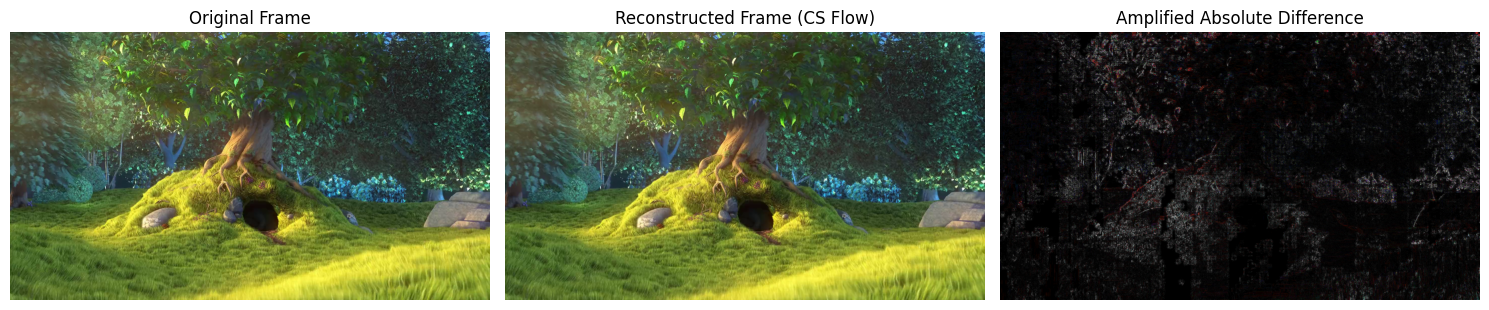

In [22]:
idx = 5  # frame 5

orig = frames[idx+1][:Hc, :Wc]
prev = frames[idx][:Hc, :Wc]
recon = warp_color_frame_backward(prev, rec_flows[idx])

diff = cv2.absdiff(orig, recon)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.title("Original Frame")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(recon, cv2.COLOR_BGR2RGB))
plt.title("Reconstructed Frame (CS Flow)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(10*diff)
plt.title("Amplified Absolute Difference")
plt.axis("off")

plt.tight_layout()
plt.show()

#### Optical Flow Reconstruction Error Across Frames

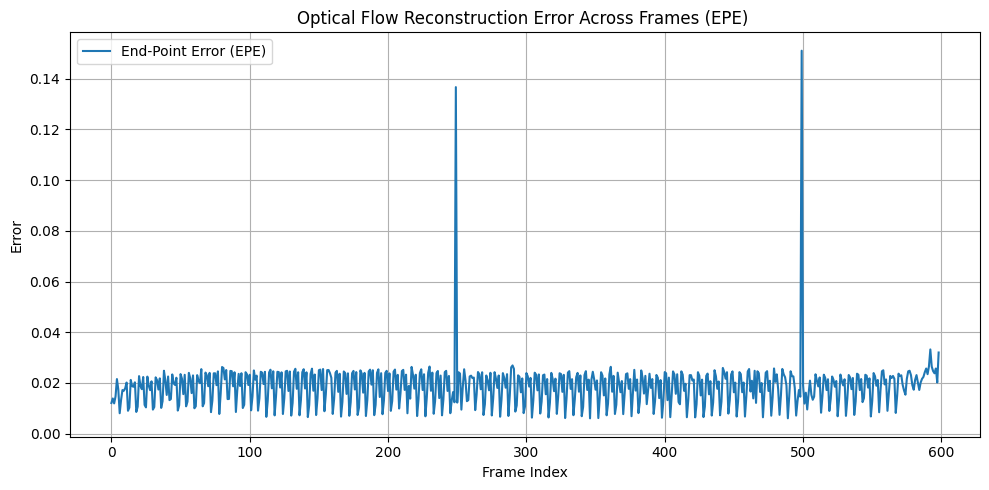

In [23]:
plt.figure(figsize=(10,5))

plt.plot(epe_list, label="End-Point Error (EPE)")
plt.xlabel("Frame Index")
plt.ylabel("Error")
plt.title("Optical Flow Reconstruction Error Across Frames (EPE) ")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


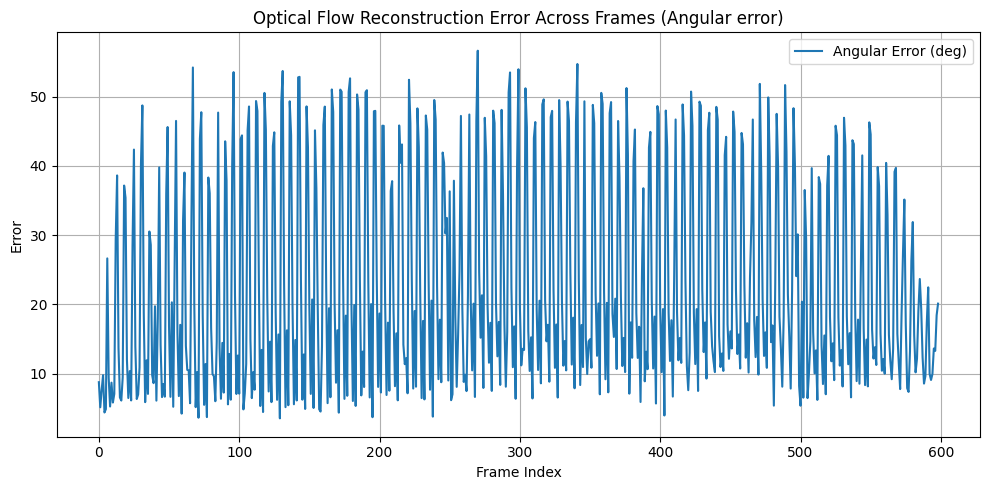

In [24]:
plt.figure(figsize=(10,5))

plt.plot(ang_list, label="Angular Error (deg)")
plt.xlabel("Frame Index")
plt.ylabel("Error")
plt.title("Optical Flow Reconstruction Error Across Frames (Angular error)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Plot of PSNR and SSIM values of Reconstructed Motion Vectors Across Frames

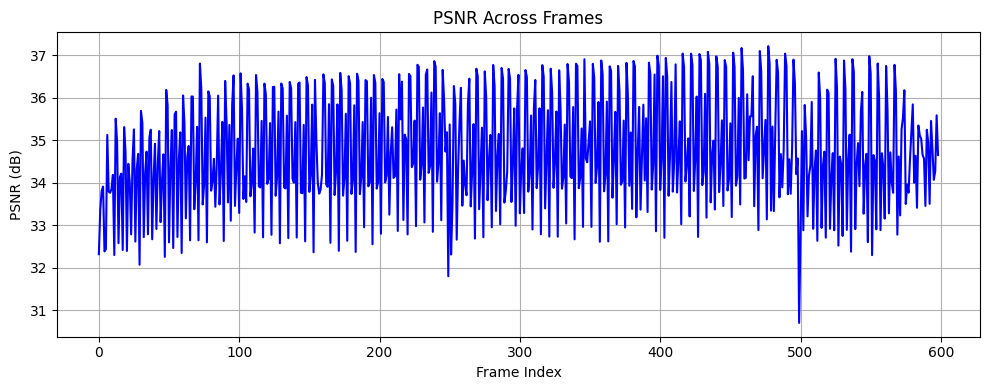

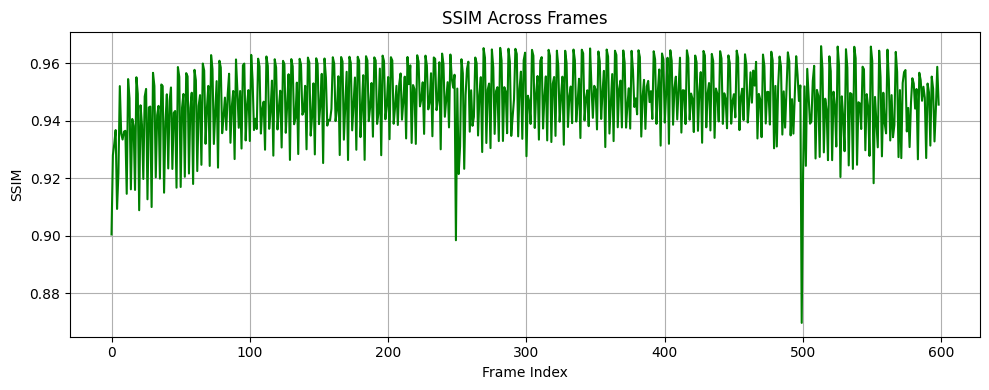

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(psnr_vals, color='blue')
plt.xlabel("Frame Index")
plt.ylabel("PSNR (dB)")
plt.title("PSNR Across Frames")
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,4))
plt.plot(ssim_vals, color='green')
plt.xlabel("Frame Index")
plt.ylabel("SSIM")
plt.title("SSIM Across Frames")
plt.grid(True)
plt.tight_layout()
plt.show()